In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas
import math
from generate_inputs import GenerateInputVector
from generate_inputs import TrajectoryLoad2
from generate_inputs import Net
from generate_inputs import device
from generate_inputs import AbsolutePose
from generate_inputs import RelativePose
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

12
[  0  27  53  79 105 131 157 177 203 229 255 281 307 333 359 385]
15


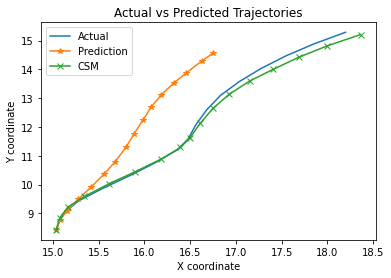

In [2]:
# Load data
traj_num = 12
# test_traj = TrajectoryLoad('./data/', traj_num , 6)
test_traj  =TrajectoryLoad2('./data/', traj_num, 100, 0.5, math.radians(10))
rel_traj_csm = pandas.read_csv('./data/traj_' + str(traj_num) + '/' + 'pose_list_CSM.csv', header=None).values
print(len(test_traj))
# for i in range(len(test_traj)):
#     sample = test_traj[i]
#     print(sample['rel_pose'])

# Loading trained network parameters

device = torch.device("cuda")
net_x = Net()
net_x = net_x.to(device)
net_x = torch.load('./net_x_4.pyt')
net_y = Net()
net_y = net_y.to(device)
net_y = torch.load('./net_y_4.pyt')
net_angle = Net()
net_angle = net_angle.to(device)
net_angle = torch.load('./net_angle_4.pyt')

# Verifying results
abs_pose_act_array = []
abs_pose_pred_array = []
rel_pose_pred_array = []
rel_pose_act_array = []
abs_pose_pred_array.append(test_traj.getStartPose())
abs_pose_act_array.append(test_traj.getStartPose())
for i in range(len(test_traj)):
    inp = np.stack([test_traj[i]['image1'], test_traj[i]['image2']])
    inp = torch.tensor(np.expand_dims(inp, axis=0)).float().cuda()
    
#     print(net_x(inp).detach().cpu().numpy())
    rel_x = net_x(inp).detach().cpu().numpy()
    rel_y = net_y(inp).detach().cpu().numpy()
    rel_angle = net_angle(inp).detach().cpu().numpy()
    rel_pose_pred = np.array([rel_x, rel_y, rel_angle])
    rel_pose_act = test_traj[i]['rel_pose']
    
    rel_pose_pred_array.append(rel_pose_pred)
    rel_pose_act_array.append(rel_pose_act)
    
    abs_pose_pred_array.append(AbsolutePose(abs_pose_pred_array[-1], rel_pose_pred))
    abs_pose_act_array.append(AbsolutePose(abs_pose_act_array[-1], rel_pose_act))
    
rel_pose_pred_array = np.squeeze(np.asarray(rel_pose_pred_array))
rel_pose_act_array = np.asarray(rel_pose_act_array)
abs_pose_act_array = np.asarray(abs_pose_act_array)
abs_pose_pred_array = np.asarray(abs_pose_pred_array)

abs_traj_csm = []
for i in range(len(rel_traj_csm)):
    abs_traj_csm.append(AbsolutePose(test_traj.getStartPose(), rel_traj_csm[i]))
abs_traj_csm = np.asarray(abs_traj_csm)
# plt.figure()
# error_x = rel_pose_act_array[:,0]-rel_pose_pred_array[:,0]
# plt.plot(error_x, label='Error')
# # plt.plot(rel_pose_pred_array[:,0], label='Prediction')
# plt.xlabel("Number of pose pairs")
# plt.ylabel("Relative pose-X (m)")
# plt.title("Relative pose-X Error | MSE = " + "{:.5f}".format(np.mean(error_x**2)))
# plt.legend()
# plt.show()

# plt.figure()
# error_y = rel_pose_act_array[:,1]-rel_pose_pred_array[:,1]
# plt.plot(error_y, label='Error')
# # plt.plot(rel_pose_pred_array[:,0], label='Prediction')
# plt.xlabel("Number of pose pairs")
# plt.ylabel("Relative pose-Y (m)")
# plt.title("Relative pose-Y Error | MSE = " + "{:.5f}".format(np.mean(error_y**2)))
# plt.legend()
# plt.show()

# plt.figure()
# error_angle = rel_pose_act_array[:,2]-rel_pose_pred_array[:,2]
# plt.plot(np.degrees(error_angle), label='Error')
# # plt.plot(rel_pose_pred_array[:,0], label='Prediction')
# plt.xlabel("Number of pose pairs")
# plt.ylabel("Relative pose-Angle (deg)")
# plt.title("Relative pose-Angle Error | MSE (rad^2)= " + "{:.5f}".format(np.mean(error_angle**2)))
# plt.legend()
# plt.show()

plt.figure()
# dir = './data/' + 'traj_' + str(4) + '/'
# pose_list = pandas.read_csv(dir + 'pose_list.csv', header=None).values
# plt.plot(pose_list[:,0], pose_list[:,1], label='Raw')
plt.plot(abs_pose_act_array[:,0], abs_pose_act_array[:,1], label='Actual')
plt.plot(abs_pose_pred_array[:,0], abs_pose_pred_array[:,1], '-*', label='Prediction')
plt.plot(abs_traj_csm[:,0], abs_traj_csm[:,1], '-x', label='CSM')
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Actual vs Predicted Trajectories")
plt.legend()
plt.show()